## Installation

Run the following cell to install all required packages if they are not already installed.

In [1]:
#!pip install matplotlib rdkit-pypi networkx torch torch-geometric

# End-to-End Molecular Discovery Workflow

This notebook demonstrates a complete workflow for molecular graph construction, visualization, and graph neural network (GNN) modeling using RDKit, NetworkX, matplotlib, and PyTorch Geometric. Each section is modular and can be adapted for your own data and functions.

## 1. Constructing a Molecular Graph with RDKit and NetworkX

We start by parsing a SMILES string and building a molecular graph. Atoms are nodes and bonds are edges.

In [2]:
# Import libraries
from rdkit import Chem
import networkx as nx

# Example SMILES string
smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)

# Build NetworkX graph
G = nx.Graph()
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), label=atom.GetSymbol())
for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), type=str(bond.GetBondType()))

print('Nodes:', G.nodes(data=True))
print('Edges:', G.edges(data=True))

Nodes: [(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'O'})]
Edges: [(0, 1, {'type': 'SINGLE'}), (1, 2, {'type': 'SINGLE'})]


## 2. Visualizing the Molecular Graph

Now, let's visualize the constructed molecular graph using NetworkX and matplotlib.

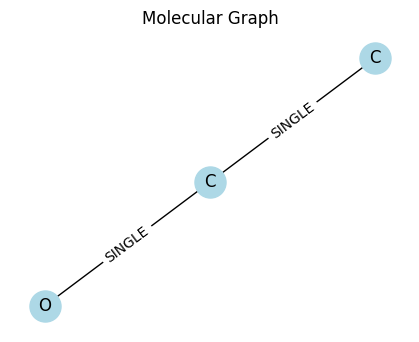

In [3]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'type')

plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Molecular Graph')
plt.show()

## 3. Building a Simple GNN Layer with PyTorch Geometric

We will now define a simple GCNConv layer and prepare random node features and edge indices.

In [4]:
# !pip install torch torch-geometric
from torch_geometric.nn import GCNConv
import torch

num_nodes = G.number_of_nodes()
x = torch.randn((num_nodes, 10))  # Random node features

# Prepare edge_index from NetworkX graph
edges = list(G.edges())
edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)
if edge_index.numel() == 0:
    edge_index = torch.empty((2, 0), dtype=torch.long)

conv = GCNConv(in_channels=10, out_channels=16)

## 4. Preparing Graph Data for PyTorch Geometric

Convert the NetworkX molecular graph to a PyTorch Geometric Data object, including node features and edge indices.

In [5]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 10], edge_index=[2, 2])


## 5. Applying the GNN Layer and Inspecting Output

Apply the GCNConv layer to the graph data and inspect the output tensor.

In [6]:
out = conv(x, edge_index)
print('GNN output shape:', out.shape)
print('Sample output:', out[:2])

GNN output shape: torch.Size([3, 16])
Sample output: tensor([[-0.2450,  0.5672, -0.1026,  0.5674, -1.0051,  0.3222,  0.3852, -0.8332,
          0.8712, -0.7118,  0.9913, -1.4977,  1.1996,  0.6271,  2.1715,  0.7734],
        [-0.6418,  0.2353,  0.0874,  0.7149, -0.5422, -0.1517,  0.7728, -0.6787,
          0.4979,  0.0918,  0.5930, -1.3363,  1.1071,  0.6958,  1.5863, -0.0557]],
       grad_fn=<SliceBackward0>)


# Expanded End-to-End Drug Discovery Workflow

This notebook demonstrates a full workflow from target identification to candidate ranking, with example functions and data for each step. Replace example data/functions with your own as needed.

## 1. Target Identification

Example: Select a disease gene or protein target (e.g., SOD1 for ALS).

In [7]:
# Example function for target selection
def select_target():
    # In practice, query Open Targets or UniProt
    return {'gene': 'SOD1', 'uniprot_id': 'P00441'}

target = select_target()
print('Selected target:', target)

Selected target: {'gene': 'SOD1', 'uniprot_id': 'P00441'}


## 2. Compound Retrieval

Example: Retrieve known ligands for the target from ChEMBL or use example SMILES.

In [8]:
# Example function for compound retrieval
def get_known_ligands(target):
    # In practice, query ChEMBL or PubChem
    return [
        {'name': 'CHEMBL273030', 'smiles': 'CCO'},
        {'name': 'CHEMBL272808', 'smiles': 'CCN(CC)CC'},
        {'name': 'CHEMBL272641', 'smiles': 'CC(C)O'}
    ]

ligands = get_known_ligands(target)
print('Retrieved ligands:', ligands)

Retrieved ligands: [{'name': 'CHEMBL273030', 'smiles': 'CCO'}, {'name': 'CHEMBL272808', 'smiles': 'CCN(CC)CC'}, {'name': 'CHEMBL272641', 'smiles': 'CC(C)O'}]


## 3. Molecular Property Calculation

Example: Calculate molecular weight and logP for each ligand using RDKit.

In [9]:
from rdkit.Chem import Descriptors
import pandas as pd

def calc_properties(ligands):
    results = []
    for lig in ligands:
        mol = Chem.MolFromSmiles(lig['smiles'])
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        results.append({
            'name': lig['name'],
            'smiles': lig['smiles'],
            'MW': mw,
            'logP': logp
        })
    return pd.DataFrame(results)

props_df = calc_properties(ligands)
props_df

,name,smiles,MW,logP
0,CHEMBL273030,CCO,46.069,-0.0014
1,CHEMBL272808,CCN(CC)CC,101.193,1.3481
2,CHEMBL272641,CC(C)O,60.096,0.3871


## 4. Descriptor/Feature Generation

Example: Generate Morgan fingerprints for each molecule.

In [10]:
from rdkit.Chem import AllChem
import numpy as np

def morgan_fingerprints(ligands, n_bits=1024):
    fps = []
    for lig in ligands:
        mol = Chem.MolFromSmiles(lig['smiles'])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        arr = np.zeros((1, n_bits), dtype=int)
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr[0])
        fps.append(arr[0])
    return np.array(fps)

X = morgan_fingerprints(ligands)
print('Fingerprint matrix shape:', X.shape)

Fingerprint matrix shape: (3, 1024)


[22:05:30] DEPRECATION WARNING: please use MorganGenerator
[22:05:30] DEPRECATION WARNING: please use MorganGenerator
[22:05:30] DEPRECATION WARNING: please use MorganGenerator


## 5. Virtual Screening/Filtering

Example: Filter molecules by property (e.g., logP < 2.5) and select top candidates.

In [11]:
# Filter by logP < 2.5
filtered = props_df[props_df['logP'] < 2.5]
print('Filtered candidates:')
filtered

Filtered candidates:


,name,smiles,MW,logP
0,CHEMBL273030,CCO,46.069,-0.0014
1,CHEMBL272808,CCN(CC)CC,101.193,1.3481
2,CHEMBL272641,CC(C)O,60.096,0.3871


## 6. ADMET Prediction (Placeholder)

Example: Predict ADMET properties (here, random values as a placeholder).

In [12]:
# Placeholder for ADMET prediction
def predict_admet(df):
    np.random.seed(0)
    df = df.copy()
    df['ADMET_score'] = np.random.rand(len(df))
    return df

admet_df = predict_admet(filtered)
admet_df

,name,smiles,MW,logP,ADMET_score
0,CHEMBL273030,CCO,46.069,-0.0014,0.548814
1,CHEMBL272808,CCN(CC)CC,101.193,1.3481,0.715189
2,CHEMBL272641,CC(C)O,60.096,0.3871,0.602763


## 7. Visualization of Top Candidates

Example: Show a table of top candidates and plot their properties.

Top candidates:


,name,smiles,MW,logP,ADMET_score
1,CHEMBL272808,CCN(CC)CC,101.193,1.3481,0.715189
2,CHEMBL272641,CC(C)O,60.096,0.3871,0.602763
0,CHEMBL273030,CCO,46.069,-0.0014,0.548814


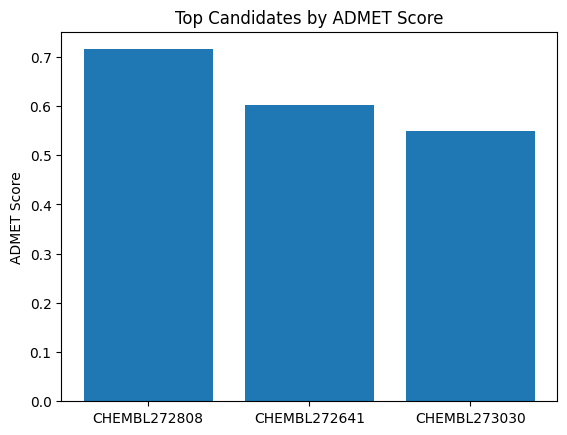

In [13]:
import matplotlib.pyplot as plt

top = admet_df.sort_values('ADMET_score', ascending=False).head(3)
print('Top candidates:')
display(top)

plt.bar(top['name'], top['ADMET_score'])
plt.ylabel('ADMET Score')
plt.title('Top Candidates by ADMET Score')
plt.show()

## 8. Export Results

Example: Save the final candidate table to a CSV file for further analysis.

In [14]:
admet_df.to_csv('final_candidates.csv', index=False)
print('Results exported to final_candidates.csv')

Results exported to final_candidates.csv


## 9. Further Analysis of Final Candidates

After exporting the final candidate table, you can perform additional computational and visualization analyses to prioritize compounds for experimental validation. Below are several common next steps.

### 9.1. Chemical Space Visualization
Visualize the diversity of your top candidates using dimensionality reduction (e.g., PCA) on their fingerprints.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume X (fingerprints) and admet_df['name'] are available
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=admet_df['ADMET_score'], cmap='viridis', s=80)
for i, name in enumerate(admet_df['name']):
    plt.text(X_pca[i,0], X_pca[i,1], name, fontsize=8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Chemical Space of Candidates (PCA)')
plt.colorbar(label='ADMET Score')
plt.show()

### 9.2. Clustering of Candidates
Cluster the candidates to identify diverse chemotypes for further study.

In [ ]:
from sklearn.cluster import KMeans

# Cluster into 2 groups as an example
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
admet_df['cluster'] = kmeans.labels_
print(admet_df[['name', 'cluster']])

### 9.3. Structure-Based Docking Preparation
Prepare input files for molecular docking simulations (e.g., with AutoDock Vina).

In [ ]:
from rdkit.Chem import AllChem, rdmolfiles

# Generate 3D conformers and save as SDF for docking
w = Chem.SDWriter('candidates_for_docking.sdf')
for i, row in admet_df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
    AllChem.UFFOptimizeMolecule(mol)
    mol.SetProp('_Name', row['name'])
    w.write(mol)
w.close()
print('3D structures saved to candidates_for_docking.sdf')

### 9.4. Advanced Visualization and Reporting
Generate summary plots and tables for presentations or publications.

In [ ]:
import seaborn as sns

# Pairplot of key properties
sns.pairplot(admet_df, vars=['MW', 'logP', 'ADMET_score'], hue='cluster')
plt.suptitle('Pairplot of Final Candidates', y=1.02)
plt.show()

### 9.5. Experimental Planning and Next Steps
Select top candidates for synthesis or purchase, and design in vitro/in vivo assays for biological validation.

In [ ]:
# Example: Select top 2 candidates for experimental validation
top2 = admet_df.sort_values('ADMET_score', ascending=False).head(2)
print('Top candidates for experimental validation:')
display(top2)